# Bruel & Kjaer 4620 vs Crinacle's 711 Coupler
This is a study of how do in-ear headphones measure on Bruel & Kjaer 4620 measurement system compared to IEC60318-4 (i.e. 711) compatible coupler

Crinacle has measured over 100 in-ear headphones using both measurement systems, allowing us to compare difference in the frequency response.
The study has three tests:

1. Individual differences between frequency responses of all in-ear headphones measured on the two systems
2. Arithmetic mean and standard deviation of the individual differences
3. Calibration of Harman 2019 in-ear target to Bruel & Kjaer 4620 measurements

## Setup
Run these cells to set up the dependencis, measurements, targets, etc...

You need to have a local copy of [AutoEq](https://github.com/jaakkopasanen/AutoEq) repository in this directory's parent's parent directory
(where audio-research-stuff lies) and have the Crinacle's numerical measurement data present there.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from autoeq.frequency_response import FrequencyResponse
from autoeq.peq import LowShelf
from calibration import calibrate

In [3]:
DIR_PATH = Path().resolve()
AUTOEQ_PATH = DIR_PATH.parent.parent.joinpath('AutoEq')
DIR_PATH.joinpath('out').mkdir(parents=True, exist_ok=True)

In [4]:
refs_711 = [FrequencyResponse.read_csv(fp) for fp in AUTOEQ_PATH.joinpath('measurements', 'crinacle', 'data', 'in-ear', '711').glob('*.csv')]
refs_711 = {fr.name: fr for fr in refs_711}
bk4620_measurements = [FrequencyResponse.read_csv(fp) for fp in AUTOEQ_PATH.joinpath('measurements', 'crinacle', 'data', 'in-ear', 'Bruel & Kjaer 4620').glob('*.csv')]

## Harman in-ear 2019
The main subject of this study. The individual differences show a clear systematic pattern in the differences.

Mean and standard deviation plot makes this easier to notice. We observe that in mid frequencies the standard deviation is very low,
meaning the measurements in this range are quite well comparable with the use of the calibration (mean difference) curve.
The standard deviation grows towards the lowest and highest frequencies, as expected.

In general, the in-ear headphones measure significantly brighter on the Bruel & Kjaer 4620 system compared to the IEC60318-4 coupler.
This needs to be taken into account in the frequency response target, if one intends to use that as a basis for equalization.

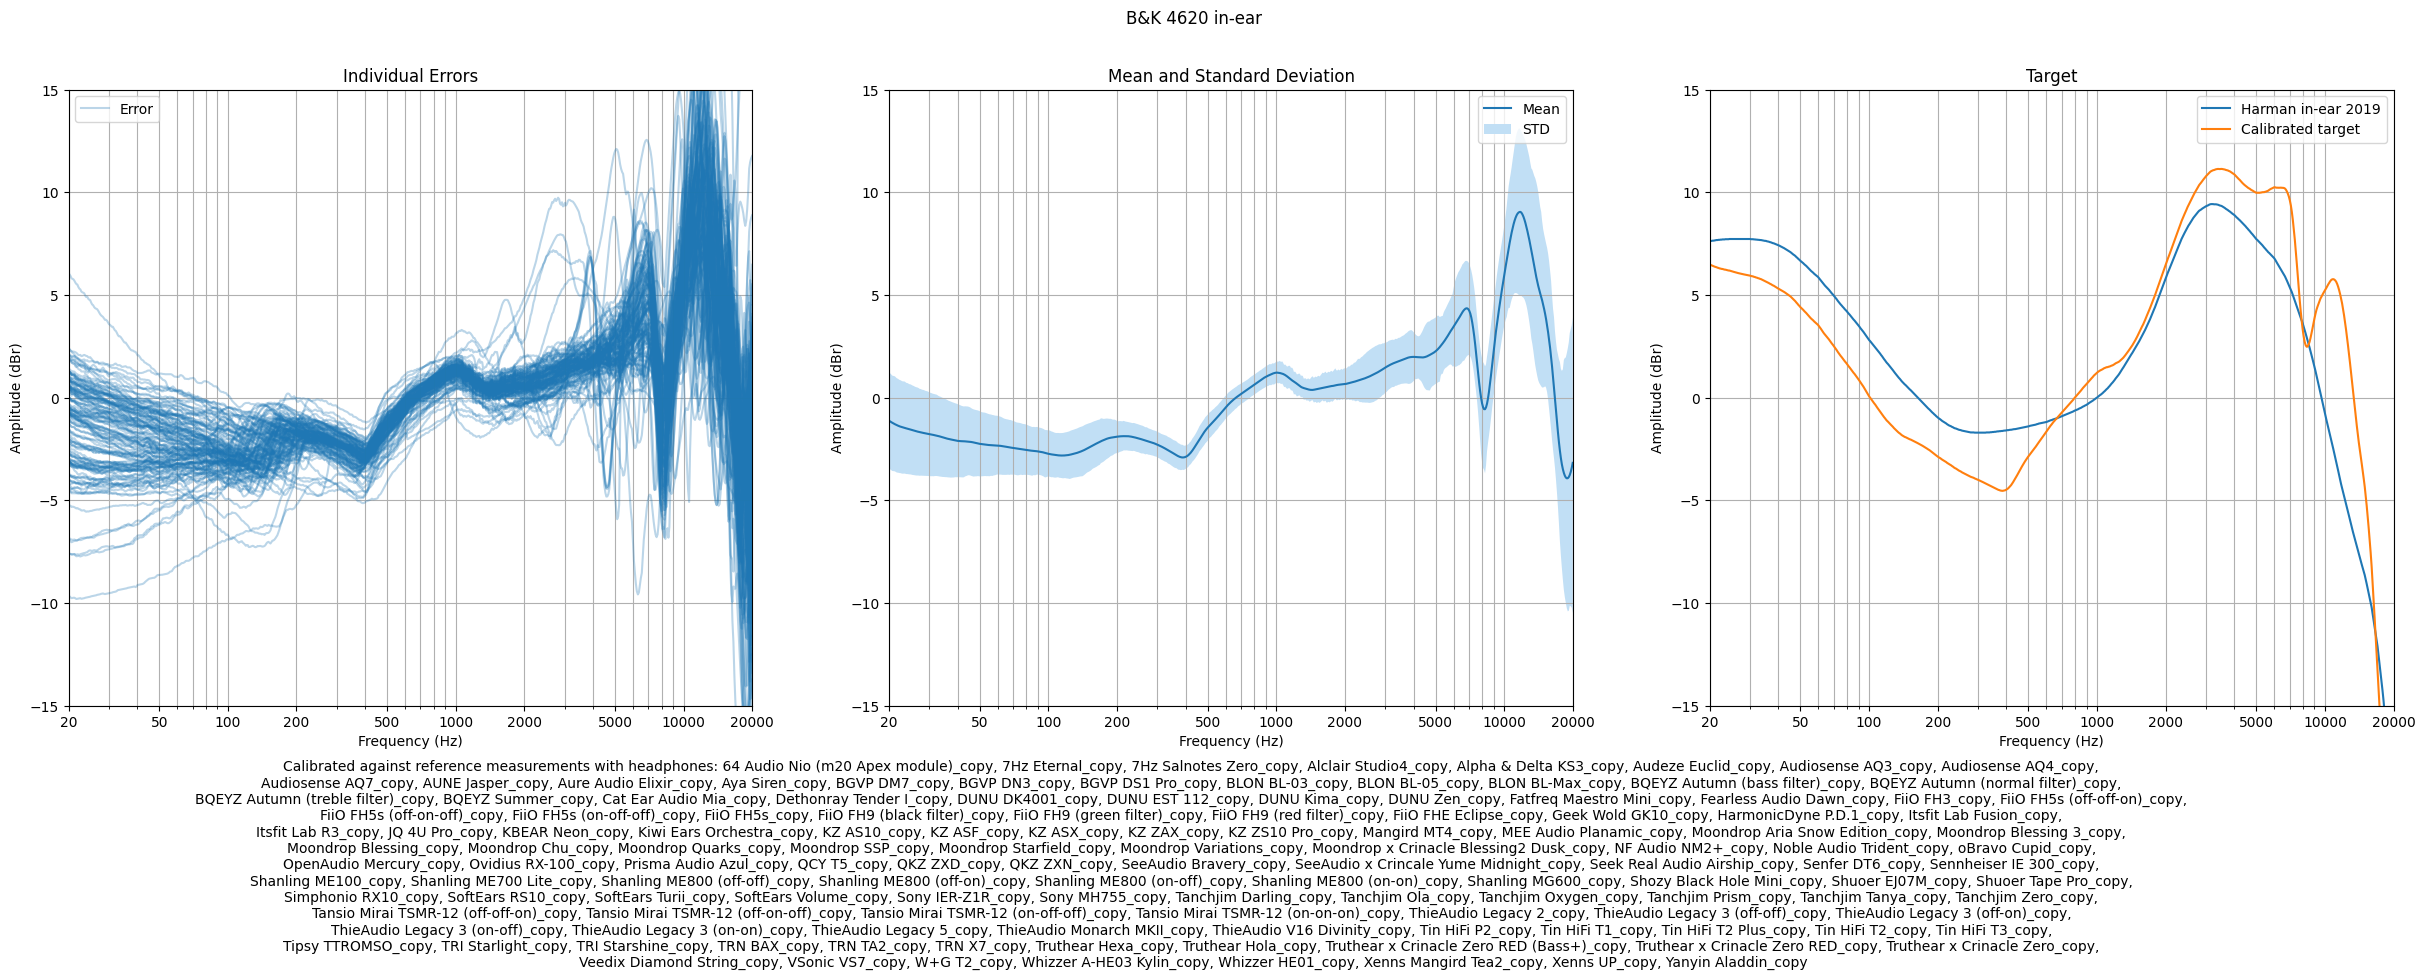

In [5]:
errors, mean, calibrated_target, fig = calibrate(
    'B&K 4620', 'in-ear', bk4620_measurements, refs_711,
    FrequencyResponse.read_csv(AUTOEQ_PATH.joinpath('targets', 'Harman in-ear 2019.csv')))
plt.show()

## Calibrated Harman vs Tilted Diffuse Field
How does the calibrated Harman in-ear 2019 target compare to Bruel & Kjaer 5128 HATS's diffuse field target?
Some claims have been made that diffuse field target with a downward tilt of about 1 dB per octave should
be the ideal target response for headphone measurements performed on Bruel & Kjaer 5128 and 4620 systems.

We can observe that the tilted 5128 diffuse field response is a very poor fit to the calibrated Harman in-ear
2019 target.

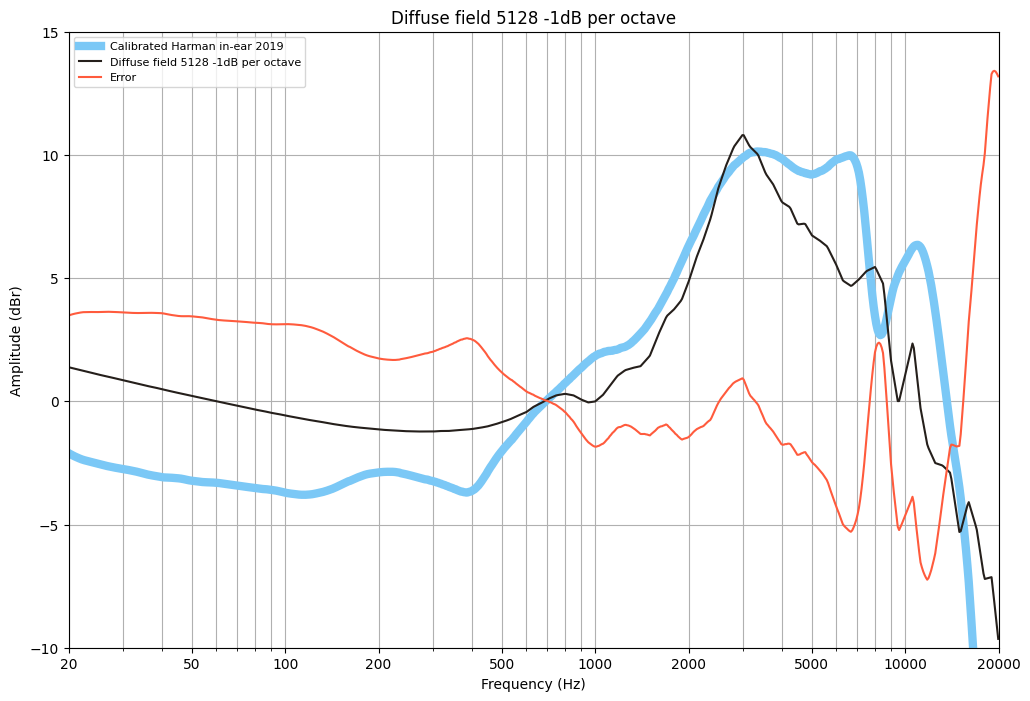

In [12]:
df_5128_tilted = FrequencyResponse.read_csv(AUTOEQ_PATH.joinpath('targets', 'Diffuse field 5128 -1dB per octave.csv'))
df_5128_tilted.interpolate()
df_5128_tilted.center()
df_5128_tilted.compensate(calibrated_target, min_mean_error=True)
fig, ax = df_5128_tilted.plot(show_fig=False, raw_plot_kwargs={'label': 'Diffuse field 5128 -1dB per octave'}, target_plot_kwargs={'label': 'Calibrated Harman in-ear 2019'})
ax.set_ylim([-10, 15])
plt.show()

### Non-tilted Diffuse Field
Would non-tilted diffuse field response of the 5128 HATS with a bass shelf fit better for the calibrated target?

We observe from the difference (Error curve) between the calibrated target and the 5128 diffuse field response that
the fit in general is quite good with individual small deviations and a slight general trend for the diffuse field
response to be warmer than the calibrated target.

Often a low shelf filter with center frequency of 105 Hz and quality of 0.7 is used for bass boosting, but in this
instance quality of 0.58 and center frequency of 80 Hz matches serves better to match the calibrated target. The
original 2019 Harman in-ear target has about 9.5 dB of bass shelf gain but once here 2 dB more is required.

The 400 Hz notch in the calibrated target appears to be a measurement artefact but should arguably exist in the
target curve because otherwise the notch gets unnecessarily compensated when equalizing to the target.

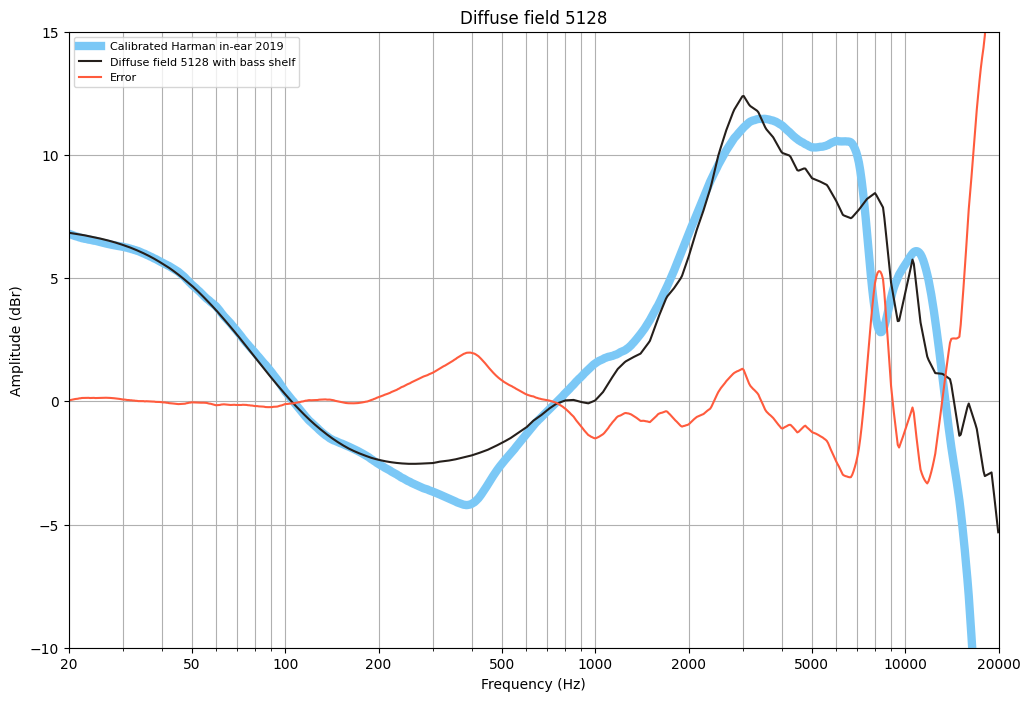

In [7]:
df_5128 = FrequencyResponse.read_csv(AUTOEQ_PATH.joinpath('targets', 'Diffuse field 5128.csv'))
df_5128.interpolate()
df_5128.center()
df_5128.raw += LowShelf(df_5128.frequency, 44100, fc=80.0, q=0.58, gain=11.5).fr
df_5128.compensate(calibrated_target, min_mean_error=True)
fig, ax = df_5128.plot(show_fig=False, raw_plot_kwargs={'label': 'Diffuse field 5128 with bass shelf'}, target_plot_kwargs={'label': 'Calibrated Harman in-ear 2019'})
ax.set_ylim([-10, 15])
plt.show()

### Harman in-ear 2019 vs tilted diffuse field
When comparing the tilted 5128 diffuse field response to the original 2019 Harman in-ear target, we can see that the
tilted diffuse field response is a lot better match than it is for the calibrated target (excluding bass shelf). Since
the in-ear headphones measure significantly brighter on the Bruel & Kjaer 4620 system, the target must also reflect
this difference and therefore the tilted diffuse field response (which is similar to the uncalibrated Harman target)
cannot be a suitable target for in-ear headphones measured on 4620.

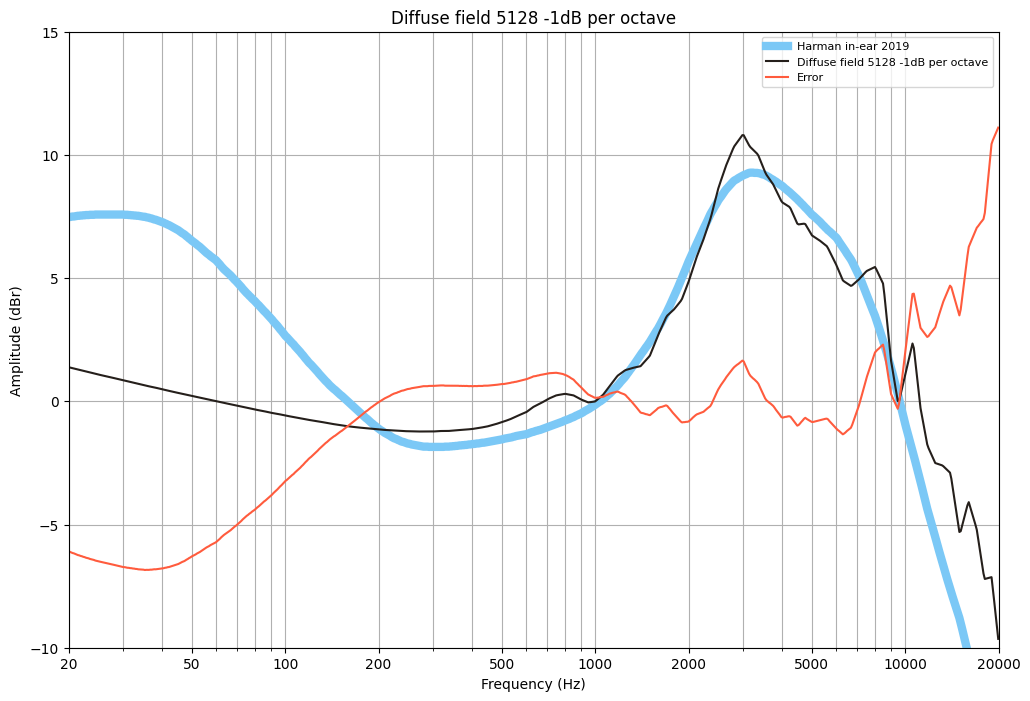

In [13]:
df_5128_tilted = FrequencyResponse.read_csv(AUTOEQ_PATH.joinpath('targets', 'Diffuse field 5128 -1dB per octave.csv'))
df_5128_tilted.interpolate()
df_5128_tilted.center()
harman_ie_2019 = FrequencyResponse.read_csv(AUTOEQ_PATH.joinpath('targets', 'Harman in-ear 2019.csv'))
df_5128_tilted.compensate(harman_ie_2019, min_mean_error=True)
fig, ax = df_5128_tilted.plot(show_fig=False, raw_plot_kwargs={'label': 'Diffuse field 5128 -1dB per octave'}, target_plot_kwargs={'label': 'Harman in-ear 2019'})
ax.set_ylim([-10, 15])
plt.show()

## Comparison against different targets

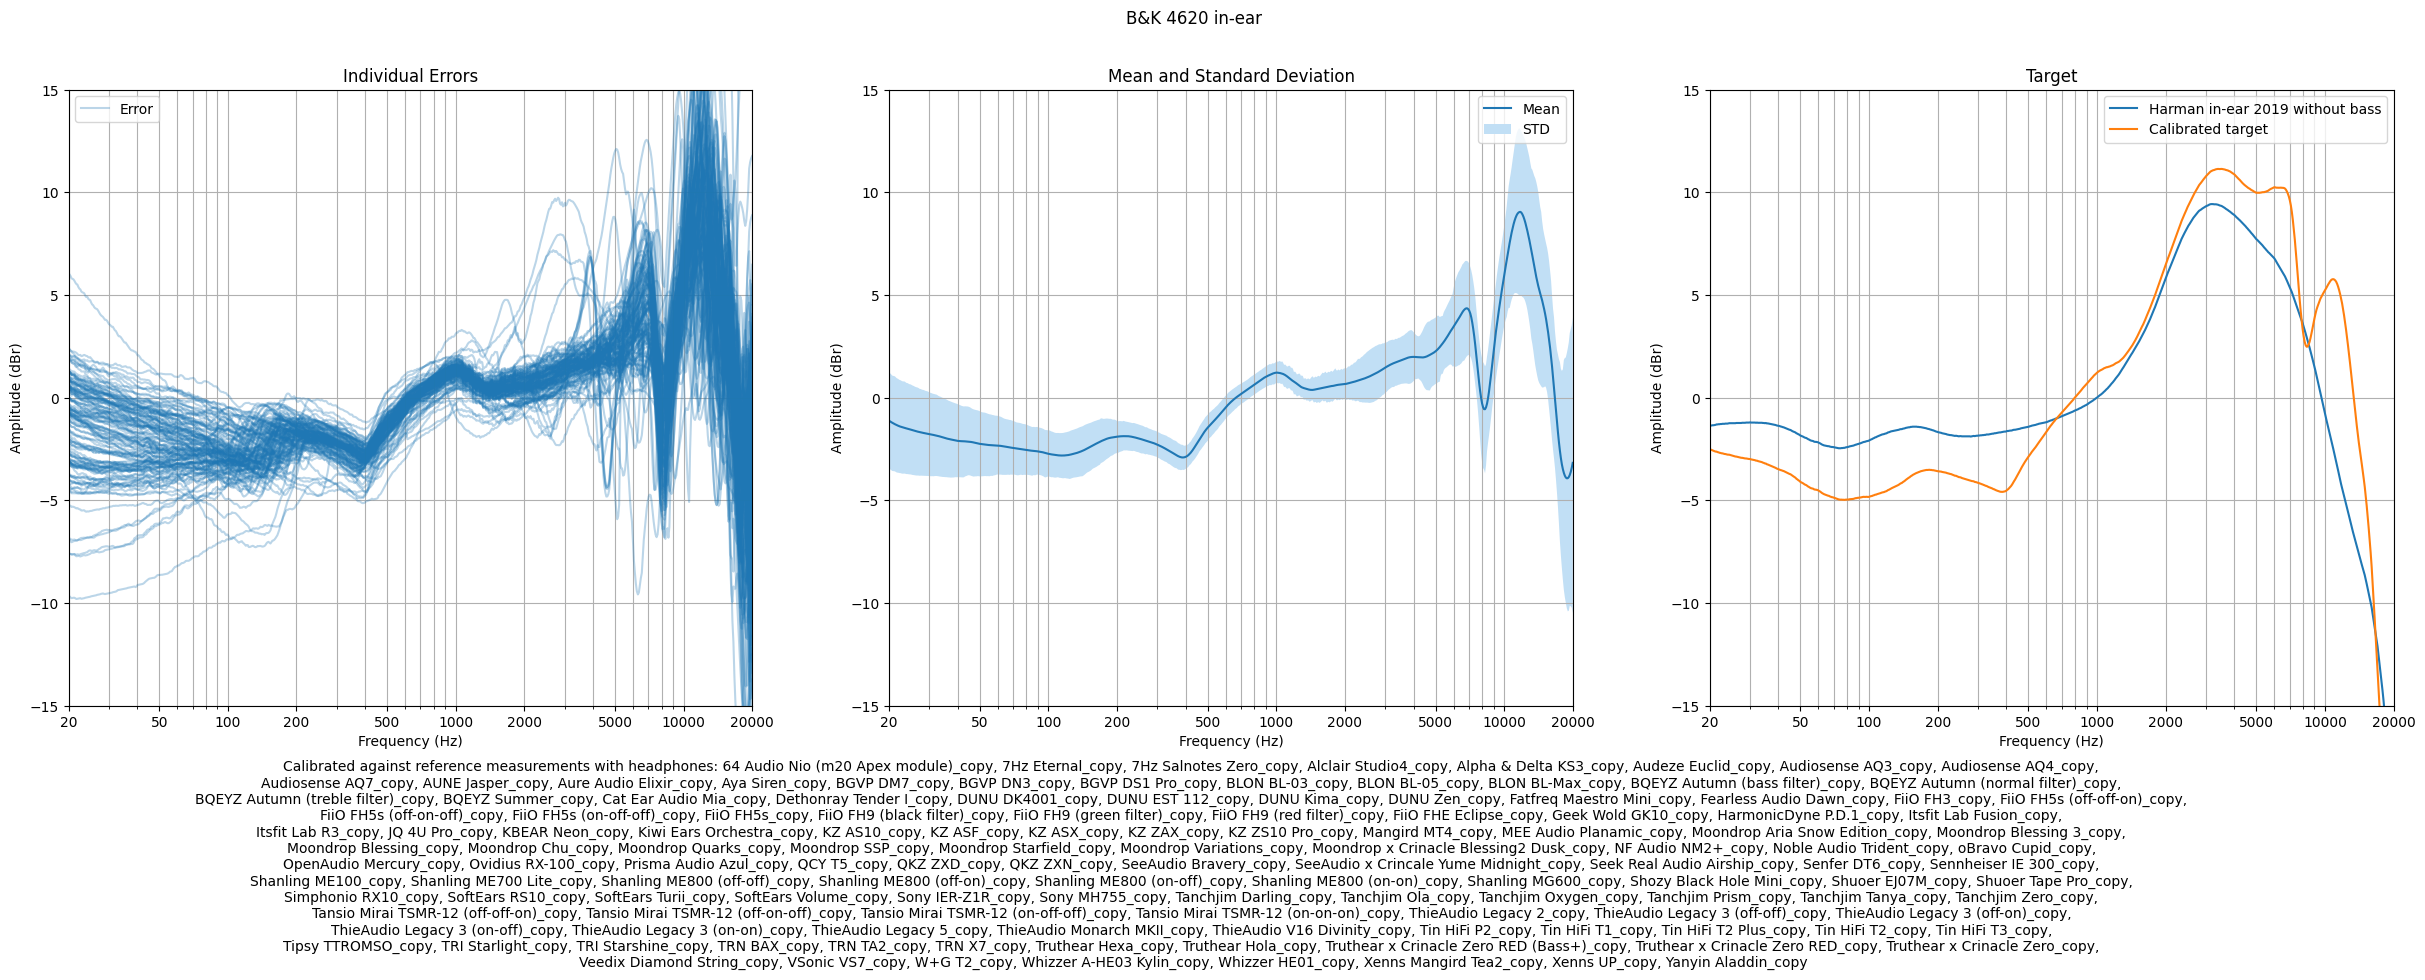

In [9]:
errors, mean, calibrated_target, fig = calibrate(
    'B&K 4620', 'in-ear', bk4620_measurements, refs_711,
    FrequencyResponse.read_csv(AUTOEQ_PATH.joinpath('targets', 'Harman in-ear 2019 without bass.csv')))
plt.show()

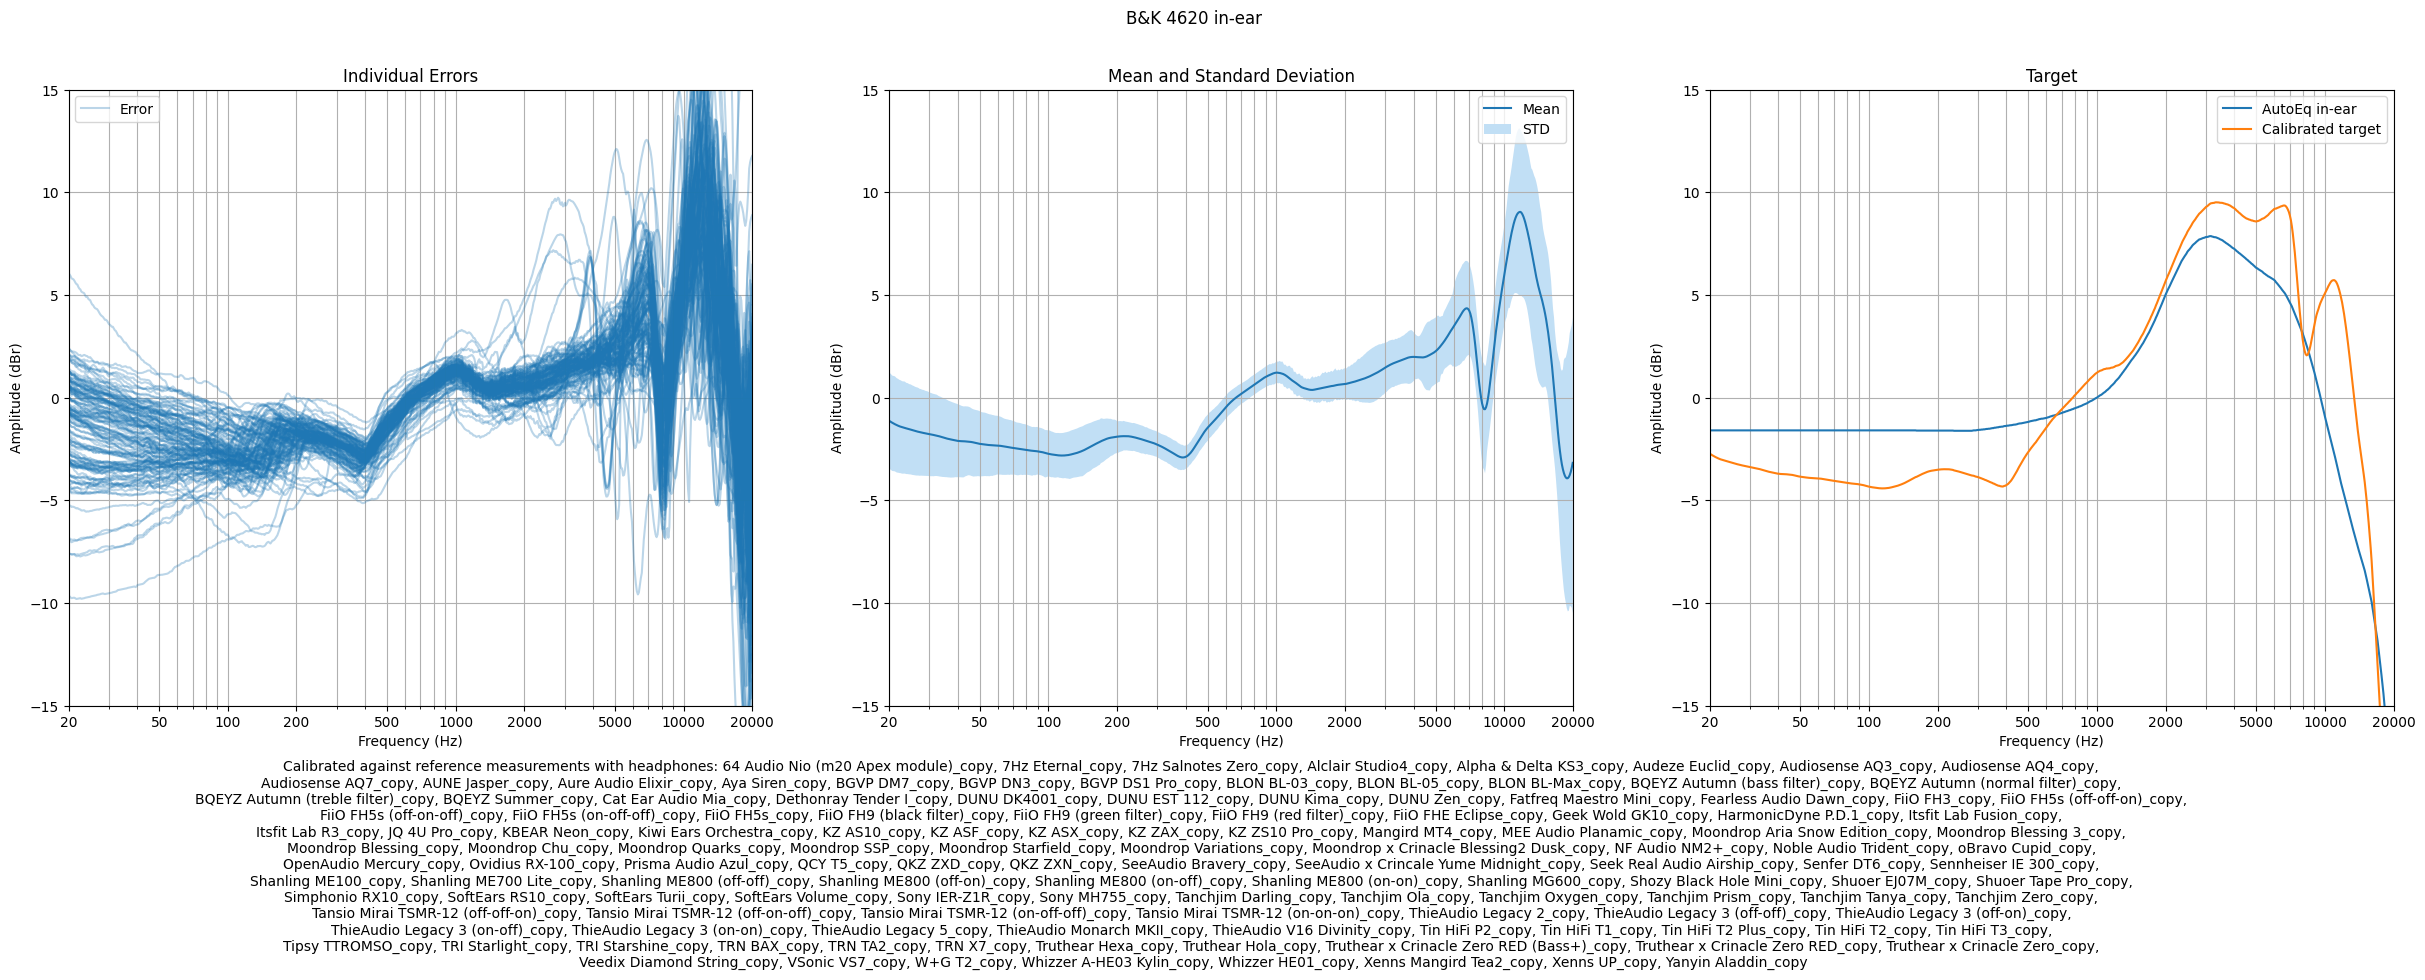

In [10]:
errors, mean, calibrated_target, fig = calibrate(
    'B&K 4620', 'in-ear', bk4620_measurements, refs_711,
    FrequencyResponse.read_csv(AUTOEQ_PATH.joinpath('targets', 'AutoEq in-ear.csv')))
plt.show()